In [1]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.distributions import Normal
import random
import pretty_midi
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import collect_song
from amc_dl.torch_plus.train_utils import get_zs_from_dists, kl_with_normal

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

DATA_PATH = os.path.join('data', 'POP09-PIANOROLL-4-bin-quantization')
INDEX_FILE_PATH = os.path.join('data', 'index.xlsx')
SEED = 3345

In [4]:
batch_size = 128
data_loaders = \
    collect_song.MusicDataLoaders.get_loaders(SEED, bs_train=batch_size,
                                    bs_val=batch_size,
                                    portion=8, shift_low=-6, shift_high=5,
                                    num_bar=2,
                                    contain_chord=True, random_train=False,
                                    random_val=False)
train_loader = data_loaders.train_loader
val_loader = data_loaders.val_loader

val_dataset = val_loader.dataset
print(len(val_dataset.data), val_dataset.indicator.shape)
inds, lengths = collect_song.get_valid_song_inds(val_dataset.valid_inds)
# ind: the serial no of the starting bar. length: number of bars.
# So batch size is equal to length/2.

print(inds[0: 10], lengths[0: 10])
for i, (ind, length) in enumerate(zip(inds, lengths)):
    batch = collect_song.get_whole_song_data(val_dataset, ind, length, shift=0)
    for b in batch:
        print(b.size())
    if i == 0:
        break

The folder contains 886 .npz files.
Selected 858 files, all are in duple meter.
705216 7513
8170 (8170,)
[10, 46, 124, 171, 196, 317, 348, 403, 472, 575] [36, 78, 36, 25, 117, 31, 55, 69, 103, 55]
torch.Size([18, 1, 32, 130])
torch.Size([32, 128, 3])
torch.Size([18, 32, 128])
torch.Size([18, 32, 16, 6])
torch.Size([18, 8, 36])
torch.Size([18, 32, 16, 39])


In [5]:
for i, data in enumerate(train_loader):
    print(data[4].shape)
    if i == 0:
        break

torch.Size([128, 8, 36])


Remain the chord encoder-decoder stucure. Here we have not added teacher forcing.

In [6]:
class ChdEncoder(nn.Module):
    def __init__(self, input_dim=36, hidden_dim=256, z_dim=256):
        super(ChdEncoder, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True,
                          bidirectional=True)
        self.linear_mu = nn.Linear(hidden_dim * 2, z_dim)
        self.linear_var = nn.Linear(hidden_dim * 2, z_dim)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

    def forward(self, x):
        # input: (B, 8, 36); output: (B, 256)
        x = self.gru(x)[-1]  # the final hidden state of shape (B, 2, 256)
        x = x.transpose_(0, 1).contiguous()
        x = x.view(x.size(0), -1)
        mu = self.linear_mu(x)
        var = self.linear_var(x).exp_()
        dist = Normal(mu, var) # (B, 256)
        return dist

In [7]:
from torchsummary import summary
chdEncoder = ChdEncoder()
chdEncoder.cuda()
summary(chdEncoder, (8, 36))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 8, 512], [-1, 2, 256]]               0
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 256]         131,328
Total params: 262,656
Trainable params: 262,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 16.00
Params size (MB): 1.00
Estimated Total Size (MB): 17.00
----------------------------------------------------------------


In [8]:
class ChdDecoder(nn.Module):

    def __init__(self, input_dim=36, z_input_dim=256,
                 hidden_dim=512, z_dim=256, num_step=32):
        super(ChdDecoder, self).__init__()
        self.z2dec_hid = nn.Linear(z_dim, hidden_dim)
        self.z2dec_in = nn.Linear(z_dim, z_input_dim)
        self.gru = nn.GRU(input_dim + z_input_dim, hidden_dim,
                          batch_first=True,
                          bidirectional=False)
        self.init_input = nn.Parameter(torch.rand(36))
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        self.root_out = nn.Linear(hidden_dim, 12)
        self.chroma_out = nn.Linear(hidden_dim, 24)
        self.bass_out = nn.Linear(hidden_dim, 12)
        self.num_step = num_step

    def forward(self, z_chd):
        # z_chd: (B, z_chd_size)
        bs = z_chd.size(0)
        z_chd_hid = self.z2dec_hid(z_chd).unsqueeze(0)
        z_chd_in = self.z2dec_in(z_chd).unsqueeze(1)
        token = self.init_input.repeat(bs, 1).unsqueeze(1)
        recon_root = []
        recon_chroma = []
        recon_bass = []

        for t in range(int(self.num_step / 4)):
            chd, z_chd_hid = \
                self.gru(torch.cat([token, z_chd_in], dim=-1), z_chd_hid)
            r_root = self.root_out(chd)  # (bs, 1, 12)
            r_chroma = self.chroma_out(chd).view(bs, 1, 12, 2).contiguous()
            r_bass = self.bass_out(chd)  # (bs, 1, 12)
            recon_root.append(r_root)
            recon_chroma.append(r_chroma)
            recon_bass.append(r_bass)

            t_root = torch.zeros(bs, 1, 12).to(z_chd.device).float()
            t_root[torch.arange(0, bs), 0, r_root.max(-1)[-1]] = 1.
            t_chroma = r_chroma.max(-1)[-1].float()
            t_bass = torch.zeros(bs, 1, 12).to(z_chd.device).float()
            t_bass[torch.arange(0, bs), 0, r_bass.max(-1)[-1]] = 1.
            token = torch.cat([t_root, t_chroma, t_bass], dim=-1)
            if t == self.num_step - 1:
                break
        
        recon_root = torch.cat(recon_root, dim=1)
        recon_chroma = torch.cat(recon_chroma, dim=1)
        recon_bass = torch.cat(recon_bass, dim=1)
        return recon_root, recon_chroma, recon_bass  # (bs, 8, 12), (bs, 8, 12, 2), (bs, 8, 12)

In [9]:
chdDecoder = ChdDecoder()
chdDecoder.cuda()
summary(chdDecoder, (256,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         131,584
            Linear-2                  [-1, 256]          65,792
               GRU-3  [[-1, 1, 512], [-1, 2, 512]]               0
            Linear-4                [-1, 1, 12]           6,156
            Linear-5                [-1, 1, 24]          12,312
            Linear-6                [-1, 1, 12]           6,156
               GRU-7  [[-1, 1, 512], [-1, 2, 512]]               0
            Linear-8                [-1, 1, 12]           6,156
            Linear-9                [-1, 1, 24]          12,312
           Linear-10                [-1, 1, 12]           6,156
              GRU-11  [[-1, 1, 512], [-1, 2, 512]]               0
           Linear-12                [-1, 1, 12]           6,156
           Linear-13                [-1, 1, 24]          12,312
           Linear-14          

The texture encoder. The original code choose to run *PtvaeEncoder()* as default instead.

In [10]:
class TextureEncoder(nn.Module):

    def __init__(self, emb_size=256, hidden_dim=1024, z_dim=256, num_channel=10):
        '''input must be piano_mat: (B, 32, 128)'''
        super(TextureEncoder, self).__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, num_channel, kernel_size=(4, 12),
                                           stride=(4, 1), padding=0),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=(1, 4),
                                              stride=(1, 4)))
        self.fc1 = nn.Linear(num_channel * 29, 1000)
        self.fc2 = nn.Linear(1000, emb_size)
        self.gru = nn.GRU(emb_size, hidden_dim, batch_first=True,
                          bidirectional=True)
        self.linear_mu = nn.Linear(hidden_dim * 2, z_dim)
        self.linear_var = nn.Linear(hidden_dim * 2, z_dim)
        self.emb_size = emb_size
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

    def forward(self, pr):
        # pr: (bs, 32, 128)
        bs = pr.size(0)
        pr = pr.unsqueeze(1)
        pr = self.cnn(pr).view(bs, 8, -1)
        pr = self.fc2(self.fc1(pr))  # (bs, 8, emb_size)
        pr = self.gru(pr)[-1]  # (2, bs, hidden_size)
        pr = pr.transpose_(0, 1).contiguous()
        pr = pr.view(pr.size(0), -1)  # (bs, 2 * hidden_size)
        mu = self.linear_mu(pr)
        var = self.linear_var(pr).exp_()
        dist = Normal(mu, var)
        return dist

The texture decoder as *PtvaeDecoder*.

In [11]:
class PtvaeDecoder(nn.Module):

    def __init__(self, device=None, note_embedding=None,
                 max_simu_note=16, max_pitch=127, min_pitch=0,
                 pitch_sos=128, pitch_eos=129, pitch_pad=130,
                 dur_pad=2, dur_width=5, num_step=32,
                 note_emb_size=128, z_size=512,
                 dec_emb_hid_size=128,
                 dec_time_hid_size=1024, dec_notes_hid_size=512,
                 dec_z_in_size=256, dec_dur_hid_size=16):
        super(PtvaeDecoder, self).__init__()
        # Parameters
        # note and time
        self.max_pitch = max_pitch  # the highest pitch in train/val set.
        self.min_pitch = min_pitch  # the lowest pitch in train/val set.
        self.pitch_sos = pitch_sos
        self.pitch_eos = pitch_eos
        self.pitch_pad = pitch_pad
        self.pitch_range = max_pitch - min_pitch + 3  # 88, not including pad.
        self.dur_pad = dur_pad
        self.dur_width = dur_width
        self.note_size = self.pitch_range + dur_width
        self.max_simu_note = max_simu_note  # the max # of notes at each ts.
        self.num_step = num_step  # 32

        # device
        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.note_emb_size = note_emb_size
        self.z_size = z_size

        # decoder
        self.dec_z_in_size = dec_z_in_size
        self.dec_emb_hid_size = dec_emb_hid_size
        self.dec_time_hid_size = dec_time_hid_size
        self.dec_init_input = \
            nn.Parameter(torch.rand(2 * self.dec_emb_hid_size))
        self.dec_notes_hid_size = dec_notes_hid_size
        self.dur_sos_token = nn.Parameter(torch.rand(self.dur_width))
        self.dec_dur_hid_size = dec_dur_hid_size

        # Modules
        # For both encoder and decoder
        if note_embedding is None:
            self.note_embedding = nn.Linear(self.note_size, note_emb_size)
        else:
            self.note_embedding = note_embedding
        self.z2dec_hid_linear = nn.Linear(self.z_size, dec_time_hid_size)
        self.z2dec_in_linear = nn.Linear(self.z_size, dec_z_in_size)
        self.dec_notes_emb_gru = nn.GRU(note_emb_size, dec_emb_hid_size,
                                        num_layers=1, batch_first=True,
                                        bidirectional=True)
        self.dec_time_gru = \
            nn.GRU(dec_z_in_size + 2 * dec_emb_hid_size,
                   dec_time_hid_size,
                   num_layers=1, batch_first=True,
                   bidirectional=False)
        self.dec_time_to_notes_hid = nn.Linear(dec_time_hid_size,
                                               dec_notes_hid_size)
        self.dec_notes_gru = nn.GRU(dec_time_hid_size + note_emb_size,
                                    dec_notes_hid_size,
                                    num_layers=1, batch_first=True,
                                    bidirectional=False)
        self.pitch_out_linear = nn.Linear(dec_notes_hid_size, self.pitch_range)
        self.dec_dur_gru = nn.GRU(dur_width, dec_dur_hid_size,
                                  num_layers=1, batch_first=True,
                                  bidirectional=False)
        self.dur_hid_linear = nn.Linear(self.pitch_range + dec_notes_hid_size,
                                        dec_dur_hid_size)
        self.dur_out_linear = nn.Linear(dec_dur_hid_size, 2)

    def get_len_index_tensor(self, ind_x):
        """Calculate the lengths ((B, 32), torch.LongTensor) of pgrid."""
        with torch.no_grad():
            lengths = self.max_simu_note - \
                      (ind_x[:, :, :, 0] - self.pitch_pad == 0).sum(dim=-1)
            # number of notes in each simu_note
        return lengths

    def index_tensor_to_multihot_tensor(self, ind_x):
        """Transfer piano_grid to multi-hot piano_grid."""
        # ind_x: (B, 32, max_simu_note, 1 + dur_width)
        with torch.no_grad():
            dur_part = ind_x[:, :, :, 1:].float()
            out = torch.zeros(
                [ind_x.size(0) * self.num_step * self.max_simu_note,
                 self.pitch_range + 1],
                dtype=torch.float).to(self.device)

            out[range(0, out.size(0)), ind_x[:, :, :, 0].view(-1)] = 1.
            out = out.view(-1, 32, self.max_simu_note, self.pitch_range + 1)
            out = torch.cat([out[:, :, :, 0: self.pitch_range], dur_part],
                            dim=-1)
            # (B, 32, max_simu_note, note_size) where 
            # note_size = 128 pitches + <SOS>,<EOS> + 5 duration = pitch_range + 5 duration = 135
            # 128 is default. In fact given by max_pitch - min_pitch + 1 (=86?).
        return out

    def get_sos_token(self):
        sos = torch.zeros(self.note_size)
        sos[self.pitch_sos] = 1.
        sos[self.pitch_range:] = 2.  # duration part
        sos = sos.to(self.device)
        return sos

    def dur_ind_to_dur_token(self, inds, batch_size):
        token = torch.zeros(batch_size, self.dur_width)
        token[range(0, batch_size), inds] = 1.
        token = token.to(self.device)
        return token

    def pitch_dur_ind_to_note_token(self, pitch_inds, dur_inds, batch_size):
        token = torch.zeros(batch_size, self.note_size)
        token[range(0, batch_size), pitch_inds] = 1.
        token[:, self.pitch_range:] = dur_inds
        token = token.to(self.device)
        token = self.note_embedding(token)
        return token

    def decode_note(self, note_summary, batch_size):
        # note_summary: (B, 1, dec_notes_hid_size)
        # This function estimate pitch, and dur for a single pitch based on note_summary.
        # Returns: est_pitch (B, 1, pitch_range), est_durs (B, 1, dur_width, 2)

        # The estimated pitch is calculated by a linear layer.
        est_pitch = self.pitch_out_linear(note_summary).squeeze(1)
        # est_pitch: (B, pitch_range)

        # The estimated dur is calculated by a 5-step gru.
        dur_hid = note_summary.transpose(0, 1)
        # dur_hid: (1, B, dec_notes_hid_size)
        dur_hid = \
            self.dur_hid_linear(torch.cat([dur_hid,
                                           est_pitch.unsqueeze(0)],
                                          dim=-1))
        token = self.dur_sos_token.repeat(batch_size, 1).unsqueeze(1)
        # token: (B, 1, dur_width)

        est_durs = torch.zeros(batch_size, self.dur_width, 2)
        est_durs = est_durs.to(self.device)

        for t in range(self.dur_width):
            token, dur_hid = self.dec_dur_gru(token, dur_hid)
            est_dur = self.dur_out_linear(token).squeeze(1)
            est_durs[:, t] = est_dur
            if t == self.dur_width - 1:
                break
            token_inds = est_dur.max(1)[1]
            token = self.dur_ind_to_dur_token(token_inds,
                                              batch_size).unsqueeze(1)
        return est_pitch, est_durs

    def decode_notes(self, notes_summary, batch_size, notes, inference,
                     teacher_forcing_ratio=0.5):
        # notes_summary: (B, 1, dec_time_hid_size)
        # notes: (B, max_simu_note, note_emb_size), ground_truth
        notes_summary_hid = \
            self.dec_time_to_notes_hid(notes_summary.transpose(0, 1))
        if inference:
            assert teacher_forcing_ratio == 0
            assert notes is None
            sos = self.get_sos_token()  # (note_size,)
            token = self.note_embedding(sos).repeat(batch_size, 1).unsqueeze(1)
            # hid: (B, 1, note_emb_size)
        else:
            token = notes[:, 0].unsqueeze(1)

        predicted_notes = torch.zeros(batch_size, self.max_simu_note,
                                      self.note_emb_size)
        predicted_notes[:, :, self.pitch_range:] = 2.
        predicted_notes[:, 0] = token.squeeze(1)  # fill sos index
        lengths = torch.zeros(batch_size)
        predicted_notes = predicted_notes.to(self.device)
        lengths = lengths.to(self.device)
        pitch_outs = []
        dur_outs = []

        for t in range(1, self.max_simu_note):
            note_summary, notes_summary_hid = \
                self.dec_notes_gru(torch.cat([notes_summary, token], dim=-1),
                                   notes_summary_hid)
            # note_summary: (B, 1, dec_notes_hid_size)
            # notes_summary_hid: (1, B, dec_time_hid_size)

            est_pitch, est_durs = self.decode_note(note_summary, batch_size)
            # est_pitch: (B, pitch_range)
            # est_durs: (B, dur_width, 2)

            pitch_outs.append(est_pitch.unsqueeze(1))
            dur_outs.append(est_durs.unsqueeze(1))
            pitch_inds = est_pitch.max(1)[1]
            dur_inds = est_durs.max(2)[1]
            predicted = self.pitch_dur_ind_to_note_token(pitch_inds, dur_inds,
                                                         batch_size)
            # predicted: (B, note_size)

            predicted_notes[:, t] = predicted
            eos_samp_inds = (pitch_inds == self.pitch_eos)
            lengths[eos_samp_inds & (lengths == 0)] = t

            if t == self.max_simu_note - 1:
                break
            teacher_force = random.random() < teacher_forcing_ratio
            if inference or not teacher_force:
                token = predicted.unsqueeze(1)
            else:
                token = notes[:, t].unsqueeze(1)
        lengths[lengths == 0] = t
        pitch_outs = torch.cat(pitch_outs, dim=1)
        dur_outs = torch.cat(dur_outs, dim=1)
        return pitch_outs, dur_outs, predicted_notes, lengths

    def decoder(self, z, inference, x, lengths, teacher_forcing_ratio1,
                teacher_forcing_ratio2):
        # z: (B, z_size)
        # x: (B, num_step, max_simu_note, note_emb_size)
        # x and lengths and fed by x, lengths = self.decoder.emb_x(x) later
        batch_size = z.size(0)
        z_hid = self.z2dec_hid_linear(z).unsqueeze(0)
        # z_hid: (1, B, dec_time_hid_size)
        z_in = self.z2dec_in_linear(z).unsqueeze(1)
        # z_in: (B, dec_z_in_size)

        if inference:
            assert x is None
            assert lengths is None
            assert teacher_forcing_ratio1 == 0
            assert teacher_forcing_ratio2 == 0
        else:
            x_summarized = x.view(-1, self.max_simu_note, self.note_emb_size)
            x_summarized = pack_padded_sequence(x_summarized, lengths.view(-1),
                                                batch_first=True,
                                                enforce_sorted=False)
            x_summarized = self.dec_notes_emb_gru(x_summarized)[-1].\
                transpose(0, 1).contiguous()
            x_summarized = x_summarized.view(-1, self.num_step,
                                             2 * self.dec_emb_hid_size)

        pitch_outs = []
        dur_outs = []
        token = self.dec_init_input.repeat(batch_size, 1).unsqueeze(1)
        # (B, 2 * dec_emb_hid_size)

        for t in range(self.num_step):
            notes_summary, z_hid = \
                self.dec_time_gru(torch.cat([token, z_in], dim=-1), z_hid)
            if inference:
                pitch_out, dur_out, predicted_notes, predicted_lengths = \
                    self.decode_notes(notes_summary, batch_size, None,
                                      inference, teacher_forcing_ratio2)
            else:
                pitch_out, dur_out, predicted_notes, predicted_lengths = \
                    self.decode_notes(notes_summary, batch_size, x[:, t],
                                      inference, teacher_forcing_ratio2)
            pitch_outs.append(pitch_out.unsqueeze(1))
            dur_outs.append(dur_out.unsqueeze(1))
            if t == self.num_step - 1:
                break

            teacher_force = random.random() < teacher_forcing_ratio1
            if teacher_force and not inference:
                token = x_summarized[:, t].unsqueeze(1)
            else:
                token = pack_padded_sequence(predicted_notes,
                                             predicted_lengths,
                                             batch_first=True,
                                             enforce_sorted=False)
                token = self.dec_notes_emb_gru(token)[-1].\
                    transpose(0, 1).contiguous()
                token = token.view(-1, 2 * self.dec_emb_hid_size).unsqueeze(1)
        pitch_outs = torch.cat(pitch_outs, dim=1)
        dur_outs = torch.cat(dur_outs, dim=1)
        # print(pitch_outs.size())
        # print(dur_outs.size())
        return pitch_outs, dur_outs

    def forward(self, z, inference, x, lengths, teacher_forcing_ratio1,
                teacher_forcing_ratio2):
        return self.decoder(z, inference, x, lengths, teacher_forcing_ratio1,
                            teacher_forcing_ratio2)

    def recon_loss(self, x, recon_pitch, recon_dur, weights=(1, 0.5),
                   weighted_dur=False):
        pitch_loss_func = \
            nn.CrossEntropyLoss(ignore_index=self.pitch_pad)
        recon_pitch = recon_pitch.view(-1, recon_pitch.size(-1))
        gt_pitch = x[:, :, 1:, 0].contiguous().view(-1)
        pitch_loss = pitch_loss_func(recon_pitch, gt_pitch)

        dur_loss_func = \
            nn.CrossEntropyLoss(ignore_index=self.dur_pad)
        if not weighted_dur:
            recon_dur = recon_dur.view(-1, 2)
            gt_dur = x[:, :, 1:, 1:].contiguous().view(-1)
            dur_loss = dur_loss_func(recon_dur, gt_dur)
        else:
            recon_dur = recon_dur.view(-1, self.dur_width, 2)
            gt_dur = x[:, :, 1:, 1:].contiguous().view(-1, self.dur_width)
            dur0 = dur_loss_func(recon_dur[:, 0, :], gt_dur[:, 0])
            dur1 = dur_loss_func(recon_dur[:, 1, :], gt_dur[:, 1])
            dur2 = dur_loss_func(recon_dur[:, 2, :], gt_dur[:, 2])
            dur3 = dur_loss_func(recon_dur[:, 3, :], gt_dur[:, 3])
            dur4 = dur_loss_func(recon_dur[:, 4, :], gt_dur[:, 4])
            w = torch.tensor([1, 0.6, 0.4, 0.3, 0.3],
                             device=recon_dur.device).float()
            dur_loss = \
                w[0] * dur0 + \
                w[1] * dur1 + \
                w[2] * dur2 + \
                w[3] * dur3 + \
                w[4] * dur4
        loss = weights[0] * pitch_loss + weights[1] * dur_loss
        return loss, pitch_loss, dur_loss

    def emb_x(self, x):
        # x: (B, num_step, max_simu_note, 1 + dur_width)
        lengths = self.get_len_index_tensor(x)
        x = self.index_tensor_to_multihot_tensor(x)  # x: (B, num_step, max_simu_note, note_size)
        embedded = self.note_embedding(x)
        return embedded, lengths

    def output_to_numpy(self, recon_pitch, recon_dur):
        est_pitch = recon_pitch.max(-1)[1].unsqueeze(-1)  # (B, 32, 11, 1)
        est_dur = recon_dur.max(-1)[1]  # (B, 32, 11, 5)
        est_x = torch.cat([est_pitch, est_dur], dim=-1)  # (B, 32, 11, 6)
        # est_x = est_x.cpu().numpy()
        # recon_pitch = recon_pitch.cpu().numpy()
        # recon_dur = recon_dur.cpu().numpy()
        est_x = est_x.cpu().detach().numpy()
        recon_pitch = recon_pitch.cpu().detach().numpy()
        recon_dur = recon_dur.cpu().detach().numpy()
        return est_x, recon_pitch, recon_dur

    def pr_to_notes(self, pr, bpm=80, start=0., one_hot=False):
        pr_matrix = self.pr_to_pr_matrix(pr, one_hot)  # oops, some strange reference. This method unused.
        alpha = 0.25 * 60 / bpm
        notes = []
        for t in range(32):
            for p in range(128):
                if pr_matrix[t, p] >= 1:
                    s = alpha * t + start
                    e = alpha * (t + pr_matrix[t, p]) + start
                    notes.append(pretty_midi.Note(100, int(p), s, e))
        return notes

    def grid_to_pr_and_notes(self, grid, bpm=60., start=0.):
        # sample(x): (32, max_simu_note, 1 + dur_width)
        if grid.shape[1] == self.max_simu_note:
            grid = grid[:, 1:]
        pr = np.zeros((32, 128), dtype=int)
        alpha = 0.25 * 60 / bpm
        notes = []
        for t in range(32):
            for n in range(10):
                note = grid[t, n]
                if note[0] == self.pitch_eos:
                    break
                pitch = note[0] + self.min_pitch
                dur = int(''.join([str(_) for _ in note[1:]]), 2) + 1
                pr[t, pitch] = min(dur, 32 - t)
                notes.append(
                    pretty_midi.Note(100, int(pitch), start + t * alpha,
                                     start + (t + dur) * alpha))
        return pr, notes

The global loss function.

In [12]:
class VAEloss(nn.Module):

    def __init__(self):
        super(VAEloss, self).__init__()
        return

    def forward(self, chd, x, recon_chd, recon_txt, dist1, dist2):
        '''
        chd: list [root, chroma, bass] , each of shape (bs, 8, 12)
        recon_chd: list [recon_root, recon_chroma, recon_bass]
        '''
        self.chord_loss = self.chd_loss_func(chd, recon_chd)
        self.score_loss = self.txt_loss_func(x, recon_txt)[0]
        self.kl_loss = self.kl_loss_func(dist1, dist2)
        return self.chord_loss + self.score_loss + self.kl_loss
    
    def chd_loss_func(self, chd, recon_chd):
        loss_fun = nn.CrossEntropyLoss()
        root = chd[:, :, 0: 12].max(-1)[-1].view(-1).contiguous()
        chroma = chd[:, :, 12: 24].long().view(-1).contiguous()
        bass = chd[:, :, 24:].max(-1)[-1].view(-1).contiguous()

        recon_root, recon_chroma, recon_bass = recon_chd
        recon_root = recon_root.view(-1, 12).contiguous()
        recon_chroma = recon_chroma.view(-1, 2).contiguous()
        recon_bass = recon_bass.view(-1, 12).contiguous()
        root_loss = loss_fun(recon_root, root)
        chroma_loss = loss_fun(recon_chroma, chroma)
        bass_loss = loss_fun(recon_bass, bass)
        chord_loss = root_loss + chroma_loss + bass_loss

        return chord_loss

    def txt_loss_func(self, x, recon_txt, weights=(1, 0.5), weighted_dur=False):
        recon_pitch, recon_dur = recon_txt
        pitch_loss_func = nn.CrossEntropyLoss(ignore_index=130)  # pitch_pad = 130
        recon_pitch = recon_pitch.view(-1, recon_pitch.size(-1))
        gt_pitch = x[:, :, 1:, 0].contiguous().view(-1)
        pitch_loss = pitch_loss_func(recon_pitch, gt_pitch)

        dur_loss_func = nn.CrossEntropyLoss(ignore_index=2)  # dur_pad = 2
        if not weighted_dur:
            recon_dur = recon_dur.view(-1, 2)
            gt_dur = x[:, :, 1:, 1:].contiguous().view(-1)
            dur_loss = dur_loss_func(recon_dur, gt_dur)
        else:
            recon_dur = recon_dur.view(-1, self.dur_width, 2)
            gt_dur = x[:, :, 1:, 1:].contiguous().view(-1, self.dur_width)
            dur0 = dur_loss_func(recon_dur[:, 0, :], gt_dur[:, 0])
            dur1 = dur_loss_func(recon_dur[:, 1, :], gt_dur[:, 1])
            dur2 = dur_loss_func(recon_dur[:, 2, :], gt_dur[:, 2])
            dur3 = dur_loss_func(recon_dur[:, 3, :], gt_dur[:, 3])
            dur4 = dur_loss_func(recon_dur[:, 4, :], gt_dur[:, 4])
            w = torch.tensor([1, 0.6, 0.4, 0.3, 0.3],
                             device=device).float()
            dur_loss = \
                w[0] * dur0 + \
                w[1] * dur1 + \
                w[2] * dur2 + \
                w[3] * dur3 + \
                w[4] * dur4
        loss = weights[0] * pitch_loss + weights[1] * dur_loss
        return loss, pitch_loss, dur_loss
    
    def kl_loss_func(self, dist1, dist2):
        kl_chd = kl_with_normal(dist1)
        kl_rhy = kl_with_normal(dist2)
        kl_loss = kl_chd + kl_rhy
        return kl_loss

In [13]:
class TransformerVAE(nn.Module):
    def __init__(self):
        super(TransformerVAE, self).__init__()
        self.chdEncoder = ChdEncoder()
        self.chdDecoder = ChdDecoder()
        self.txtEncoder = TextureEncoder()
        self.txtDecoder = PtvaeDecoder()

    def forward(self, pr, x, chd, tfr1=0.6, tfr2=0.5):
        dist_chd = self.chdEncoder(chd)
        dist_txt = self.txtEncoder(pr)
        z_chd, z_txt = get_zs_from_dists([dist_chd, dist_txt], True)
        dec_z = torch.cat([z_chd, z_txt], dim=-1)

        recon_chd = self.chdDecoder(z_chd)
        embedded_x, lengths = self.txtDecoder.emb_x(x)
        recon_txt = self.txtDecoder(dec_z, False, embedded_x,
                                                    lengths, tfr1, tfr2)
                                                    
        return recon_chd, recon_txt, dist_chd, dist_txt

Training process.

- Dec 8: 2 Epochs, $lr=10^{-3}\downarrow 10^{-5}, tfr=(0,0.6,0.5)$. Saved as *checkpoint_2epochs.pkl*.
- Dec 10: 6 Epochs, $lr=10^{-3}\downarrow 10^{-5}, tfr=(0,0.6,0.5)$. Saved as *checkpoint_6epochs.pkl*.
- Dec 12: 6 Epochs, $lr=10^{-3}\downarrow 10^{-5}, tfr=(0,0.6\downarrow ,0.5\downarrow )$. Saved as *checkpoint_6_tfrschedule1.pkl*.

In [14]:
len(train_loader)

5510

In [15]:
EPOCHS = 6

transformerVAE = TransformerVAE()
transformerVAE.cuda()
criterion = VAEloss()
optimizer = torch.optim.Adam(transformerVAE.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = \
    lambda x: 0.1 ** (x/33))
loss_record = []
chord_loss_record = []
score_loss_record = []
kl_loss_record = []

transformerVAE.train()
for num_epoch in range(EPOCHS):
    for i, train_data in enumerate(train_loader):
        optimizer.zero_grad()
        pr = train_data[2].to(device).float()
        x = train_data[3].to(device)
        chd = train_data[4].to(device).float()
        bs = pr.size(0)
    
        tfr1 = 1.2/(1 + np.exp(num_epoch))
        tfr2 = 1.0/(1 + np.exp(num_epoch))

        recon_chd, recon_txt, dist_chd, dist_txt = transformerVAE(pr, x, chd, tfr1, tfr2)
        loss = criterion(chd, x, recon_chd, recon_txt, dist_chd, dist_txt)
        loss.backward()
        optimizer.step()
        if i % 10 == 9:
            loss_record.append(loss.item())
            chord_loss_record.append(criterion.chord_loss.item())
            score_loss_record.append(criterion.score_loss.item())
            kl_loss_record.append(criterion.kl_loss.item())
        if i % 100 == 99:
            print('Finish Data', i+1, 'of epoch', num_epoch)
        if i % 500 == 499:
            scheduler.step()
            torch.save(transformerVAE.state_dict(), 'checkpoint/checkpoint_6_tfrschedule1.pkl')
            print('model checkpoint saved.')
    torch.save(transformerVAE.state_dict(), 'checkpoint/checkpoint_6_tfrschedule1.pkl')
    print('model checkpoint saved.')

Finish Data 100 of epoch 0
Finish Data 200 of epoch 0
Finish Data 300 of epoch 0
Finish Data 400 of epoch 0
Finish Data 500 of epoch 0
model checkpoint saved.
Finish Data 600 of epoch 0
Finish Data 700 of epoch 0
Finish Data 800 of epoch 0
Finish Data 900 of epoch 0
Finish Data 1000 of epoch 0
model checkpoint saved.
Finish Data 1100 of epoch 0
Finish Data 1200 of epoch 0
Finish Data 1300 of epoch 0
Finish Data 1400 of epoch 0
Finish Data 1500 of epoch 0
model checkpoint saved.
Finish Data 1600 of epoch 0
Finish Data 1700 of epoch 0
Finish Data 1800 of epoch 0
Finish Data 1900 of epoch 0
Finish Data 2000 of epoch 0
model checkpoint saved.
Finish Data 2100 of epoch 0
Finish Data 2200 of epoch 0
Finish Data 2300 of epoch 0
Finish Data 2400 of epoch 0
Finish Data 2500 of epoch 0
model checkpoint saved.
Finish Data 2600 of epoch 0
Finish Data 2700 of epoch 0
Finish Data 2800 of epoch 0
Finish Data 2900 of epoch 0
Finish Data 3000 of epoch 0
model checkpoint saved.
Finish Data 3100 of epoch

In [17]:
optimizer.param_groups[0]['lr']

1.0000000000000003e-05

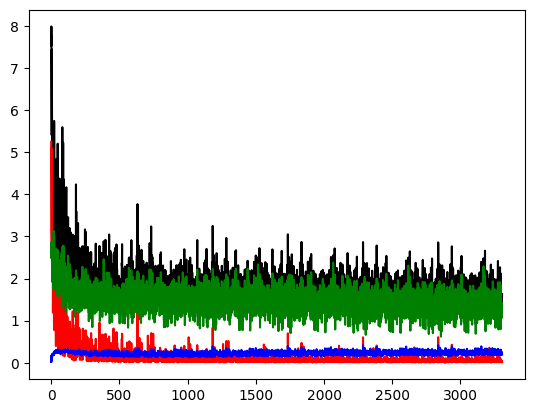

In [20]:
plt.plot(loss_record, 'k')
plt.plot(chord_loss_record, 'r')
plt.plot(score_loss_record, 'g')
plt.plot(kl_loss_record, 'b')

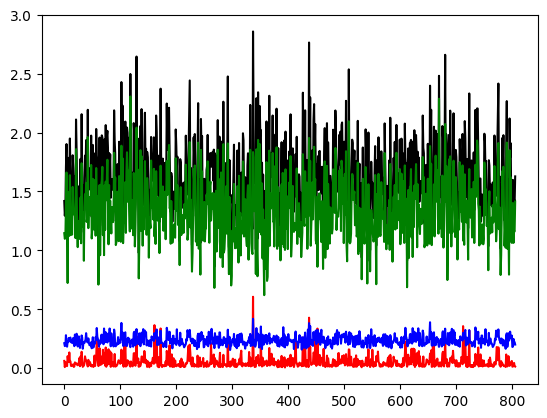

In [22]:
plt.plot(loss_record[2500:], 'k')
plt.plot(chord_loss_record[2500:], 'r')
plt.plot(score_loss_record[2500:], 'g')
plt.plot(kl_loss_record[2500:], 'b')

We first check the reproducing result.

In [35]:
transformerVAE = TransformerVAE()
transformerVAE.cuda()
transformerVAE.load_state_dict(torch.load('checkpoint/checkpoint_6_tfrschedule1.pkl'))

<All keys matched successfully>

In [16]:
def output_to_grid(recon_pitch, recon_dur):
    est_pitch = recon_pitch.max(-1)[1].unsqueeze(-1)  # (B, 32, 11, 1)
    est_dur = recon_dur.max(-1)[1]  # (B, 32, 11, 5)
    est_x = torch.cat([est_pitch, est_dur], dim=-1)  # (B, 32, 11, 6)
    est_x = est_x.cpu().numpy()
    recon_pitch = recon_pitch.cpu().numpy()
    recon_dur = recon_dur.cpu().numpy()
    return est_x, recon_pitch, recon_dur

def grid_to_pr_and_notes(grid, bpm=60., start=0.):
    if grid.shape[1] == 16:
        grid = grid[:, 1:]
    pr = np.zeros((32, 128), dtype=int)
    alpha = 0.25 * 60 / bpm
    notes = []
    for t in range(32):
        for n in range(10):
            note = grid[t, n]
            if note[0] == 129:
                break
            pitch = note[0]
            dur = int(''.join([str(_.item()) for _ in note[1:]]), 2) + 1
            pr[t, pitch] = min(dur, 32 - t)
            notes.append(
                pretty_midi.Note(100, int(pitch), start + t * alpha,
                                    start + (t + dur) * alpha))
    return pr, notes

In [17]:
def write_sample(sample, name):
    # sample: (32, max_simu_note, 1 + dur_width)
    midi = pretty_midi.PrettyMIDI(initial_tempo=60.)  # indentical to the default above
    sample_notes = grid_to_pr_and_notes(sample)[1]

    ins = pretty_midi.Instrument(0)
    ins.notes = sample_notes
    midi.instruments.append(ins)

    midi.write(name)

In [19]:
transformerVAE.eval()

for i, val_data in enumerate(val_loader):
    if i == 20:
        pr = val_data[2][0:1].to(device).float()
        x = val_data[3][0:1].to(device)
        chd = val_data[4][0:1].to(device).float()
        sample = val_data[3][0:1]
        pr1, x1, chd1, sample = pr, x, chd, sample
        break

write_sample(sample[0], 'reproducing_demo/reproduce/ground truth.mid')

dist_chd_1 = transformerVAE.chdEncoder(chd1)
dist_txt_1 = transformerVAE.txtEncoder(pr1)
z_chd_1, z_txt_1 = get_zs_from_dists([dist_chd_1, dist_txt_1], True)
dec_z = torch.cat([z_chd_1, z_txt_1], dim=-1)

recon_chd = transformerVAE.chdDecoder(z_chd_1)
embedded_x, lengths = transformerVAE.txtDecoder.emb_x(x1)
recon_txt = transformerVAE.txtDecoder(dec_z, False, embedded_x,
                                            lengths, 0., 0.)

recon_pitch, recon_dur = recon_txt
predict = transformerVAE.txtDecoder.output_to_numpy(recon_pitch, recon_dur)[0]
write_sample(predict[0], 'reproducing_demo/reproduce/generation.mid')

Now we think of interpolation: "mixing" textures of two score segments.

In [38]:
transformerVAE.eval()

for start_batch in range(0, 8, 2):

    for i, val_data in enumerate(val_loader):
        if i == 30:
            pr = val_data[2][start_batch:start_batch + 1].to(device).float()
            x = val_data[3][start_batch:start_batch + 1].to(device)
            chd = val_data[4][start_batch:start_batch + 1].to(device).float()
            sample = val_data[3][start_batch:start_batch + 1]
            pr1, x1, chd1, sample_chd = pr, x, chd, sample
        if i == 56:
            pr = val_data[2][start_batch:start_batch + 1].to(device).float()
            x = val_data[3][start_batch:start_batch + 1].to(device)
            chd = val_data[4][start_batch:start_batch + 1].to(device).float()
            sample = val_data[3][start_batch:start_batch + 1]
            pr2, x2, chd2, sample_txt = pr, x, chd, sample
            break

    write_sample(sample_chd[0], 'reproducing_demo/texturemix/sample_a_' + str(start_batch % 2) + '.mid')
    write_sample(sample_txt[0], 'reproducing_demo/texturemix/sample_b_' + str(start_batch % 2) + '.mid')

    dist_chd_1 = transformerVAE.chdEncoder(chd1)
    dist_txt_1 = transformerVAE.txtEncoder(pr1)
    z_chd_1, z_txt_1 = get_zs_from_dists([dist_chd_1, dist_txt_1], True)
    dist_chd_2 = transformerVAE.chdEncoder(chd2)
    dist_txt_2 = transformerVAE.txtEncoder(pr2)
    z_chd_2, z_txt_2 = get_zs_from_dists([dist_chd_2, dist_txt_2], True)

    dec_z = torch.cat([z_chd_1, z_txt_2], dim=-1)

    embedded_x, lengths = transformerVAE.txtDecoder.emb_x(x2)
    recon_txt = transformerVAE.txtDecoder(dec_z, False, embedded_x,
                                                lengths, 0., 0.)

    recon_pitch, recon_dur = recon_txt
    predict = transformerVAE.txtDecoder.output_to_numpy(recon_pitch, recon_dur)[0]
    write_sample(predict[0], 'reproducing_demo/texturemix/achd+btxt_' + str(start_batch % 2) + '.mid')

    dec_z = torch.cat([z_chd_2, z_txt_1], dim=-1)

    embedded_x, lengths = transformerVAE.txtDecoder.emb_x(x1)
    recon_txt = transformerVAE.txtDecoder(dec_z, False, embedded_x,
                                                lengths, 0., 0.)

    recon_pitch, recon_dur = recon_txt
    predict = transformerVAE.txtDecoder.output_to_numpy(recon_pitch, recon_dur)[0]
    write_sample(predict[0], 'reproducing_demo/texturemix/atxt+bchd_' + str(start_batch % 2) + '.mid')

Test the variation of $z_{chd}$ and $z_{txt}$ over semitone shifting.

In [ ]:
EPOCHS = 1

transformerVAE = TransformerVAE()
transformerVAE.cuda()
criterion = VAEloss()
optimizer = torch.optim.Adam(transformerVAE.parameters(), lr=0.0001) 

transformerVAE.load_state_dict(torch.load('checkpoint_3.pkl'))
transformerVAE.eval()
delta_z_chd = []
delta_z_txt = []

for i, val_data in enumerate(val_loader):
    pr1 = val_data[2][0:1].to(device).float()
    pr2 = val_data[2][1:2].to(device).float()
    x1 = val_data[3][0:1].to(device)
    x2 = val_data[3][1:2].to(device)
    chd1 = val_data[4][0:1].to(device).float()
    chd2 = val_data[4][1:2].to(device).float()
    sample_chd = val_data[3][0:1]
    sample_txt = val_data[3][1:2]
    chd2 = torch.roll(chd1, 4, 2)
    pr2 = torch.roll(pr1, 4, 2)

    dist_chd_1 = transformerVAE.chdEncoder(chd1)
    dist_txt_1 = transformerVAE.txtEncoder(pr1)
    z_chd_1, z_txt_1 = get_zs_from_dists([dist_chd_1, dist_txt_1], True)
    dist_chd_2 = transformerVAE.chdEncoder(chd2)
    dist_txt_2 = transformerVAE.txtEncoder(pr2)
    z_chd_2, z_txt_2 = get_zs_from_dists([dist_chd_2, dist_txt_2], True)

    delta_z_chd.append(torch.norm(dist_chd_1.mean - dist_chd_2.mean, p=1).item())
    delta_z_txt.append(torch.norm(dist_txt_1.mean - dist_txt_2.mean, p=1).item())

    if i == 100:
        break

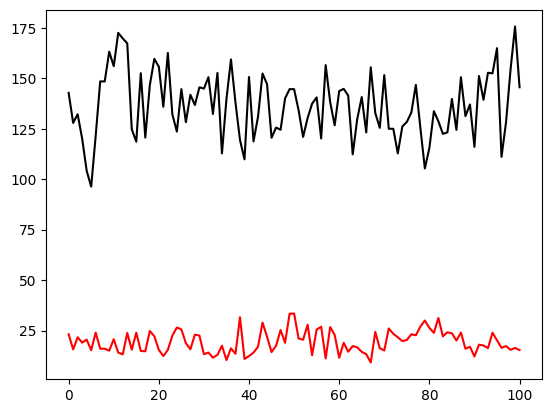

In [ ]:
plt.plot(delta_z_chd, 'k')
plt.plot(delta_z_txt, 'r')